In [1]:
import gspread as gspread
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob



from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose
)
from monai.config import print_config

print_config()

MONAI version: 0.8.0
Numpy version: 1.21.5
Pytorch version: 1.10.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.2.0
TorchVision version: 0.11.2+cu113
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
set_determinism(seed=0)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)


        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-57, a_max=164,
        #     b_min=0.0, b_max=1.0, clip=True,
        # ),

In [4]:
filename = f"C:\\Users\\1\\Downloads\\volumes 0-49\\volumes 0-49\\volume-21.nii.gz"
biggestDat, meta = LoadImage()(filename)
labelFilename = f"C:\\Users\\1\\Downloads\\volumes 0-49\\labels\\labels-21.nii.gz"
biggestDatLabel, metaLabel = LoadImage()(labelFilename)
biggestDatLabel

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

image shape: (512, 512, 826), label shape: (512, 512, 826)


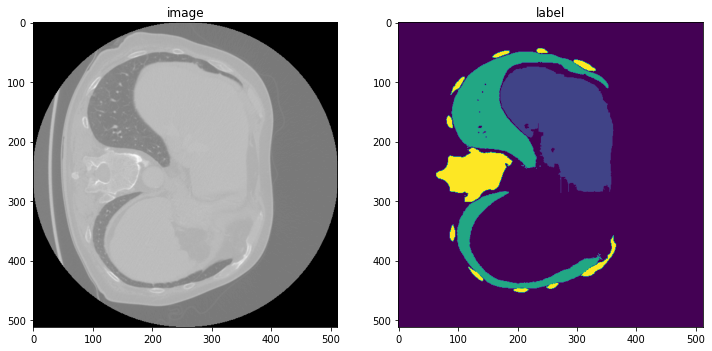

In [5]:
image, label = (biggestDat[:,:,:], biggestDatLabel[:,:,:])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 500], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 500])
plt.show()
# torch.Size([544, 419, 1720])

In [6]:
import sys

imageTensor = torch.Tensor(biggestDat)
imageLabel = torch.Tensor(biggestDatLabel)
#preparing some tensors for later comparison
onlyBladder =torch.where( imageLabel==2, 1, 0)#.to(torch.device("cuda"))
onlyLungs =torch.where( imageLabel==3, 1, 0)#.to(torch.device("cuda"))
onlyBone =torch.where( imageLabel==5, 1, 0)
sizzz = onlyBone.size()
sizzz
torch.sum(onlyLungs)




tensor(13603493)

# Testing Monai metrics

In [7]:
import torch
not_translated = onlyBone.clone().to(torch.device("cuda"))
translated = torch.zeros((sizzz)).to(torch.device("cuda"))
translated[5:512,5:512,5:826]= onlyBone.clone()[0:507,0:507,0:821]
translated.size()

torch.Size([512, 512, 826])

In [8]:
import torch
torch.cuda.is_available()

True

In [9]:
import monai
from monai.metrics import Cumulative


dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric(y_pred=torch.unsqueeze(not_translated, dim=0), y=torch.unsqueeze(translated, dim=0))  # callable to add metric to the buffer
metric = dice_metric.aggregate().item()


import monai
from monai.metrics import Cumulative
# dice_metric = DiceMetric(include_background=False, reduction="mean")
# xx= dice_metric(y_pred=eroded_image, y= not_eroded)
# metric = dice_metric.aggregate().item()
# metric
# torch.sum(monai.metrics.compute_meandice(eroded_image, not_eroded, include_background=False))
metric

0.6791306734085083

In [10]:
from torch.utils import benchmark
def diceToTest(a, b):
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    dice_metric(y_pred=a, y=b)  # callable to add metric to the buffer
    metric = dice_metric.aggregate().item()
    return metric
diceToTest(not_translated,translated)

t0 = benchmark.Timer(
    stmt='diceToTest(a, b)',
    setup='from __main__ import diceToTest',
    globals={'a':not_translated , 'b':translated })
res = t0.timeit(300)
print(res) #24,1

diceToTest(a, b)
setup: from __main__ import diceToTest
  23.81 ms
  1 measurement, 300 runs , 1 thread


In [11]:
def generalMetricBenchMarkTest(a, b, metricObj):
    metricObj(y_pred=a, y=b)  # callable to add metric to the buffer
    metric = metricObj.aggregate().item()
    return metric

# HDF5 upload

This is usefull to later on the same data run Julia benchmarks

In [12]:
import h5py
f = h5py.File("mytestfile.hdf5", "w")
f.create_dataset("not_translated", data=  not_translated.cpu().detach().numpy())
f.create_dataset("translated", data=  translated.cpu().detach().numpy())
f.create_dataset("onlyLungs", data=  onlyLungs.cpu().detach().numpy())
f.create_dataset("onlyBladder", data=  onlyBladder.cpu().detach().numpy())
f.close()


# PYMIA


In [13]:
import glob
import os

import numpy as np
import pymia.evaluation.metric as metric
import pymia.evaluation.evaluator as eval_
import pymia.evaluation.writer as writer
import SimpleITK as sitk

In [14]:
labels = {1: 'lab'
          }


In [15]:
import timeit
import statistics
from statistics import median
not_translCPU = not_translated.cpu()
translatedCPU = translated.cpu()


In [16]:
def benchPym(metr,cellStr ):
    # metrics = [metric.DiceCoefficient()]
    metrics = [metr]
    evaluator = eval_.SegmentationEvaluator(metrics, labels)
    def forBenchPymia():
        evaluator.evaluate(not_translCPU ,translatedCPU, "1")
        # writer.ConsoleWriter().write(evaluator.results)
    num_runs = 1
    num_repetions = 100
    ex_time = timeit.Timer(forBenchPymia).repeat(
                         repeat=num_repetions,
                         number=num_runs)
    res= median(ex_time)*1000
    print(res)
    res

In [17]:
benchPym(metric.DiceCoefficient(),"C2" )
benchPym(metric.JaccardCoefficient(),"C3" )
benchPym(metric.GlobalConsistencyError(),"C4" )
benchPym(metric.VolumeSimilarity(),"C5" )
benchPym(metric.AdjustedRandIndex(),"C6" )
benchPym(metric.InterclassCorrelation(),"C7" )
benchPym(metric.CohenKappaCoefficient(),"C8" )
benchPym(metric.MutualInformation(),"C9" )
benchPym(metric.VariationOfInformation(),"C10" )

2155.543800000004
2153.6750999999867


c:\users\1\pycharmprojects\pythonproject3\venv\lib\site-packages\pymia\evaluation\metric\categorical.py:377: RuntimeWarning: overflow encountered in long_scalars
  e1 = (fn * (fn + 2 * tp) / (tp + fn) + fp * (fp + 2 * tn) / (tn + fp)) / n
c:\users\1\pycharmprojects\pythonproject3\venv\lib\site-packages\pymia\evaluation\metric\categorical.py:378: RuntimeWarning: overflow encountered in long_scalars
  e2 = (fp * (fp + 2 * tp) / (tp + fp) + fn * (fn + 2 * tn) / (tn + fn)) / n


2150.011100000029


KeyboardInterrupt: 

In [18]:
#now distance metrics benchmarks

    # metrics = [metric.DiceCoefficient()]
metrics = [metric.MahalanobisDistance()]
evaluator = eval_.SegmentationEvaluator(metrics, labels)
def forBenchPymia():
        evaluator.evaluate(onlyBladder.cpu() ,onlyLungs.cpu(), "1")
        # writer.ConsoleWriter().write(evaluator.results)
        # writer.ConsoleWriter().write(evaluator.results)
num_runs = 1
num_repetions = 100
ex_time = timeit.Timer(forBenchPymia).repeat(
                         repeat=num_repetions,
                         number=num_runs)
res= median(ex_time)*1000
res

3726.296399999967